# Analyzing tweets with PCA and KMeans

In [1]:
import collections
from html import unescape
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import re
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
from TweetStore import TweetStore
import unicodedata
plt.style.use('ggplot')
%matplotlib inline


def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items()) 
        else:
            items.append((new_key, v))
    return dict(items)

In [2]:
# COUCH_SERVER = 'http://127.0.0.1:5984/'
# db = TweetStore('twitter_belgium_inc', COUCH_SERVER)
# db2 = TweetStore('twitter_locations', COUCH_SERVER)

In [3]:
# _tweets = [flatten(t) for t in db.get_tweets()]
# _tweets2 = [flatten(t) for t in db2.get_tweets()]

In [4]:
# with open('../data/tweets.json', 'w') as f:
#     json.dump(_tweets, f)
# with open('../data/tweets2.json', 'w') as f:
#     json.dump(_tweets2, f)

In [5]:
with open('../data/tweets.json') as f:
    _tweets = json.load(f)
with open('../data/tweets2.json') as f:
    _tweets2 = json.load(f)

In [6]:
all_tweets = _tweets + _tweets2
print(len(_tweets), len(_tweets2), len(all_tweets))

192416 119440 311856


In [7]:
# original dataframe
df_O = pd.DataFrame(all_tweets)
df_O.shape

(311856, 164)

In [8]:
# some functions
sample = df_O.sample(n=30)

# create id maps for translating place names
def createMap(k_series, v_series):
    keys = list(k_series)
    vals = list(v_series)
    
    return dict({(i,n) for i, n in zip(keys, vals)})

def translate(df):
    en = df[df.user_lang == 'en']
    n_en = df[df.user_lang != 'en']
    en_idMap = createMap(en.place_id, en.place_name)
    n_en_idMap = createMap(n_en.place_id, n_en.place_name)
    for k,v in n_en_idMap.items():
        if k not in en_idMap:
            en_idMap[k] = v
            
    return df["place_id"].map(en_idMap)


# text preparation
url_re = re.compile(r'(https?)?:\/\/(\w\.\w.)\/\w*')

def remove_accents(txt):
    _nfkd = unicodedata.normalize('NFKD', txt)
    return ''.join([c for c in _nfkd if not unicodedata.combining(c)])

def prep(txt):
    txt = re.sub(url_re, '', txt)
    txt = unescape(txt)
    txt = remove_accents(txt)
    txt = txt.replace('\n', ' ')
    txt = txt.replace('\t', ' ')
    
    return ''.join([w.lower() for w in txt if w.isalpha() or w.isspace()])

# test:
tweets = ['Joghurt ist wie 🦄 https://t.co/jzcstdokbG', 
       "#mairlynd Perhaps Perhaps in der #StrickBar #düsseldorf anzukuscheln auch heute im #Stricktreff… https://t.co/l3TzJcFMrw",
         "@brendairwin2001 @amypoops @lynnbanks10 @dreamon you have huge mouses in Ireland 😁🐭🐭🐭xxx"]

for tweet in tweets:
    print(prep(tweet))
print()
# joghurt ist wie  
# mairlynd perhaps perhaps in der strickbar dusseldorf anzukuscheln auch heute im stricktreff 
# brendairwin amypoops lynnbanks dreamon you have huge mouses in ireland xxx


# print pca components + the variance they explain
def loadings(vec, decomp):
    load = decomp.components_
    # for x, y, feat in zip(load[:,0], load[:,1], vec.get_feature_names()):
    for l in zip(load[:,0], load[:,1], vec.get_feature_names()):
        print('%f, %f, %s' % l)
    print('variance explained: {}'.format(decomp.explained_variance_ratio_.sum()))


# calculate the center of a bounding box
def center(b_box):
    box = [x for y in b_box for x in y]
    # het midden van de rechthoek is het gemiddelde van de coordinaten
    c = list(map(lambda x: x/4, [sum(x) for x in zip(box[0], box[1], box[2], box[3])]))
    # because twitter uses the geojson format for coordinates, we have to reverse them 
    # if we don't want to end up in the (pacifc | atlantic) ocean
    c.reverse()
    return list(c)

# test (checked coordinates using http://www.hamstermap.com/quickmap.php)
boxes = sample.place_bounding_box_coordinates

centers = [center(box) for box in boxes]
print(centers[:3])
print()

from math import asin, atan2, cos, radians, sin, sqrt
# Earth's radius in km
R = 6371.009

# calculate distance with the haversine formula (https://www.wikipedia.org/???)
def haversine(f, t):
    """ f: 'from' coordinate
        t: 'to' coordinate
        returns: distance between f and t in km
    """
    f_lat, f_long = map(radians, f)
    t_lat, t_long = map(radians, t)

    dLat = t_lat - f_lat
    dLon = t_long - f_long

    a = sin(dLat/2) * sin(dLat/2) + cos(f_lat) * cos(t_lat) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

# test
print(haversine(centers[0], centers[1]))
print()


# create a distance matrix
def haversine_distances(coords):
    """ coords: list of coordinates
        returns: distance matrix 
    """
    M = []
    for f in coords:
        d = [haversine(f, t) for t in coords]
        M.append(d)
    
    return np.matrix(M)

# test
dist = haversine_distances(centers)
print(dist.shape)

joghurt ist wie  
mairlynd perhaps perhaps in der strickbar dusseldorf anzukuscheln auch heute im stricktreff 
brendairwin amypoops lynnbanks dreamon you have huge mouses in ireland xxx

[[52.1638205, 5.395513], [52.35472800000001, 4.9040535], [50.865085, 4.155990500000001]]

39.61663274393831

(30, 30)


In [9]:
df = df_O.copy(deep=True)

# select relevant columns
df = df[['lang', 'place_bounding_box_coordinates','place_country_code', 'place_id',
       'place_name', 'place_place_type', 'text', 'user_lang','user_location']]

# translate place names
df["place_name"] = translate(df)

# get bounding box centers -- drop tweets without coordinates
df = df.dropna(subset=["place_bounding_box_coordinates"])
df["center"] = df["place_bounding_box_coordinates"].map(center)

df.shape

(311780, 10)

In [10]:
df = df.dropna(subset=["text"])
df.shape

(311780, 10)

In [11]:
df.text = df.text.map(prep)

### Creating the bags

In [12]:
# per city
admin = df.place_place_type.map(lambda x: x == 'city')
df_cities = df[admin]

cities = {}
# use the top 50 of most productive cities for exploratory purposes
for c in dict(df_cities.place_name.value_counts()[:50]).keys():
     cities[c] = ' '.join(list(df[df.place_name == c].text))

names = list(cities.keys())
tweets = list(cities.values())

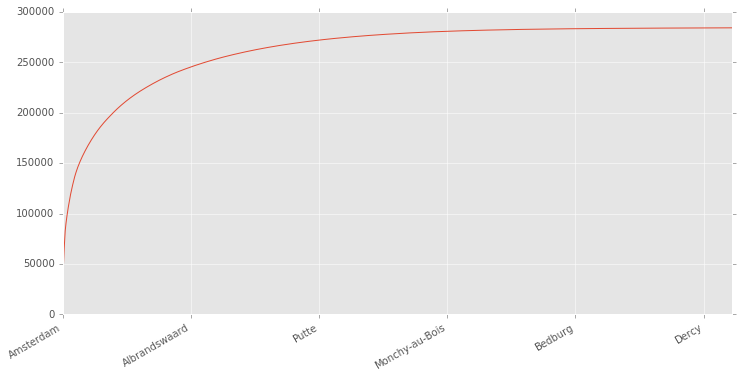

In [13]:
fig = plt.figure(figsize=(12, 6))

df_cities.place_name.value_counts().cumsum().plot()
fig.autofmt_xdate()
plt.show()

### Vectorizing

In [14]:
# vectorize
ngram_vec = TfidfVectorizer(max_df=.7, max_features=100000, min_df=.2, use_idf=True, ngram_range=(1,2))

M = ngram_vec.fit_transform(tweets)
features = ngram_vec.get_feature_names()

In [15]:
len(features)

8799

### Clustering

In [16]:
# n_clusters=5 (just a guess)
num_cls = 5
km = KMeans(n_clusters=num_cls)
km.fit(M)
clusters = km.labels_.tolist()

In [17]:
clustered = {'city' : names, 'tweet' : tweets, 'cluster' : clusters}
df_km = pd.DataFrame(clustered, index=[clusters], columns=['city', 'tweet', 'cluster'])

In [18]:
df_km['cluster'].value_counts()

2    23
1    12
3     7
4     5
0     3
Name: cluster, dtype: int64

### Visualisation

In [19]:
# features per cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_cls):
    print("Cluster {} words:".format(i), end='')
    print()
    
    # print the top 10 words that are nearest to the centroid
    for ind in order_centroids[i, :10]: 
        print('{}'.format(features[ind]), end=', ')
    print()
    print()
    
    print("Cluster {} cities:".format(i), end='')
    print()
    try:
        for title in df_km.ix[i]['city'].values.tolist():
            print('{}'.format(title), end=', ')
    except:
        print('{}'.format(df_km.ix[i]['city']))
    print()
    print()


Cluster 0 words:
mm, rain, wind, hum, temperature, hpa, op onze, meer op, kmh, onze, 

Cluster 0 cities:
Menameradiel, Apeldoorn, Zaanstad, 

Cluster 1 words:
cest, des, jai, pour, mais, est, une, tu, qui, sur, 

Cluster 1 cities:
Tourcoing, Lille, Amiens, Wemmel, Sint-Gillis, Roubaix, Schaarbeek, Villeneuve-d'Ascq, Dunkirk, Liege, Brussels, Thionville, 

Cluster 2 words:
wel, weer, heb, amsterdam, meer, goed, uit, kca, moet, deze, 

Cluster 2 cities:
Louvain, Maastricht, Nijmegen, Rotterdam, Utrecht, Eindhoven, Groningen, Spijkenisse, Deventer, Almere, The Hague, Amersfoort, Arnhem, Enschede, Leyden, Zwolle, Haarlemmermeer, Amsterdam, Haarlem, Tilburg, Dordrecht, Breda, 's-Hertogenbosch, 

Cluster 3 words:
ich, und, ist, nicht, auf, auch, hpa, von, zu, mit, 

Cluster 3 cities:
Duisburg, Düsseldorf, Essen, Dortmund, Cologne, Aachen, Bonn, 

Cluster 4 words:
antwerpen, gent, belgium, hoplr, nmbs, campus, at station, antwerp, wel, nightlife hoplr, 

Cluster 4 cities:
Ghent, Kortrijk, Ant

In [20]:
# calculate distances
cos_distance = cosine_distances(M)

In [21]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(cos_distance)  # shape (n_components, n_samples)
mds_xs, mds_ys = pos[:, 0], pos[:, 1]

In [22]:
# pca = PCA(n_components=2)
# M_bar = pca.fit_transform(M)
# pca_xs, pca_ys = M_bar[:,0], M_bar[:,1]

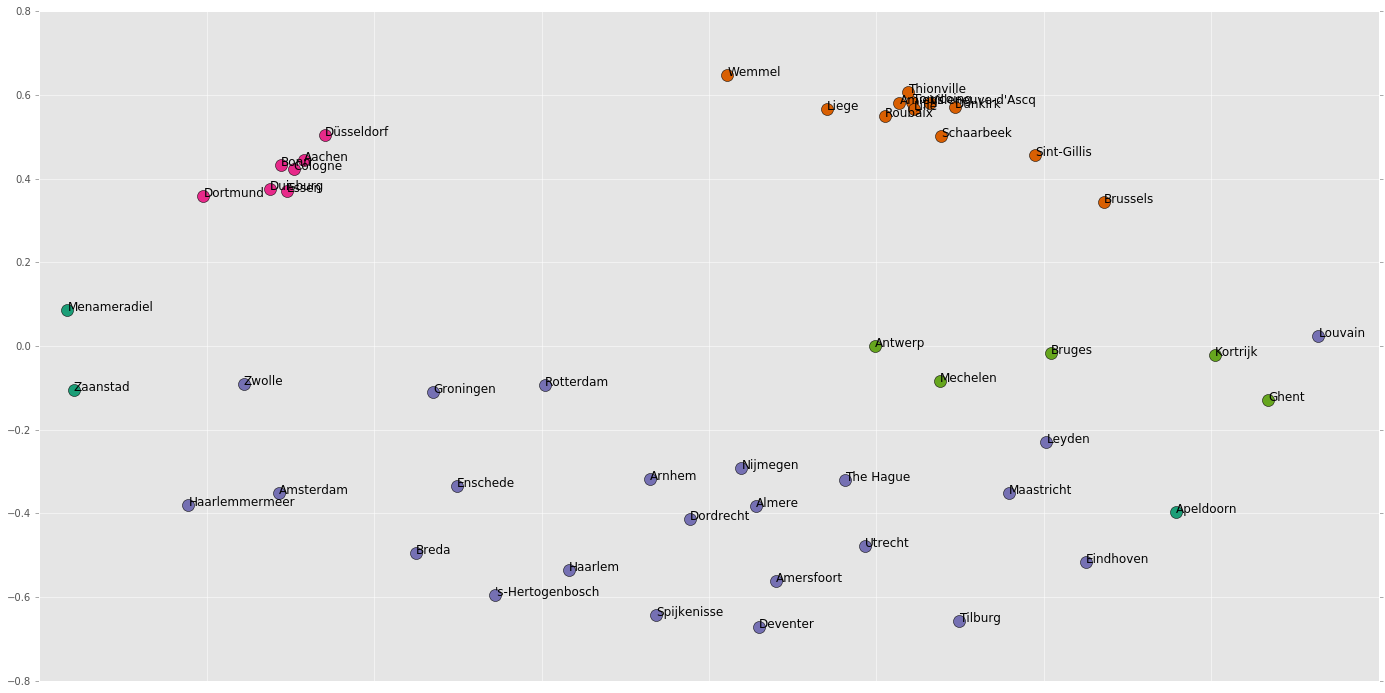

In [23]:
# plot
cluster_names = {0 : '', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7', 8 : '8', 9 : '9'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=mds_xs, y=mds_ys, label=clusters, title=names)) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(24, 12))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name])
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(axis='y', which='both', bottom='off', top='off',labelbottom='off')

# ax.legend(numpoints=1)

#add labels
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=12)  



plt.savefig('../data/clusters.jpg', dpi=400)    

plt.show()



In [24]:
# loadings(ngram_vec, pca)

NameError: name 'pca' is not defined

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(cos_distance)

fig, ax = plt.subplots(figsize=(10, 8))
ax = dendrogram(linkage_matrix, orientation="right", labels=names);

plt.tick_params(axis= 'x', which='both', bottom='off',top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('5-clusters_dendrogram', dpi=200) #save figure as ward_clusters